<img src="https://drive.google.com/thumbnail?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff&sz=w1500" width="500"/>

---


# **Variational AutoEncoders (VAEs)**

#### **Morning contents/agenda**

1. AutoEncoders

2. Variational AutoEncoders

3. Other VAE architectures

4. A simple VAE demo

#### **Learning outcomes**

1. Understand how Autoencoders can be used for data dimensionality reduction

2. Gain intuition about what a latent space is and how the latent space of Autoencoders and VAEs differ

3. Understand how the reparametrization trick makes VAEs trainable

4. Differentiate the role of the KL Divergence and reconstruction fidelity terms in the loss function of VAEs

<br>

#### **Afternoon contents/agenda**

1. Load the FashionMNIST dataset

2. Implement a convolutional VAE

3. Implement a conditioned convolutional VAE

#### **Learning outcomes**

1. Practice implementation VAEs

2. Understand how to refactor a linear VAE into a convolutional VAE

3. Learn how to perform class-conditioned generation

<br/>

---

<br/>

# Rational of Generative Models
---

Generative models are a class of unsupervised models that generate new data that is similar to the data in the training set. They are used in a variety of applications, including image and video generation, natural language processing, and music generation.

The key goal of generative models is to learn the underlying probability distribution of the data $p(x)$ of a dataset $X$ so we can draw samples from it. That is the goal of any generative model, including statistical models that do not rely on deep learning.

<br>

<p align = "center"><img src="https://drive.google.com/thumbnail?id=13yVxGyVbefU6on-QFtgS8PHHOM-CnIdE&sz=w1000" width="300"/></p><p align = "center">
<i> <a href="https://openai.com/blog/generative-models/">image source</a></i>
</p>

<!-- <p align = "center"><img src="https://drive.google.com/uc?id=13yVxGyVbefU6on-QFtgS8PHHOM-CnIdE" width="300"/></p><p align = "center">
<i> <a href="https://openai.com/blog/generative-models/">image source</a></i>
</p> -->



In the expressiveness of deep learning, however, we are able to model much more complex distributions than with traditional statistical models.

Let a neural network $G$ be a mapping function from a variable $z$ to data space, parameterised by $\theta$.

$$
G(z;\theta) \rightarrow x \sim \hat{p}(x),
$$

where $z$ is a random variable from a prior distribution $p(z)$ that we can compute, $x$ is the generated data, $\hat{p}(x)$ is the probability density function of the generated data.

If we want our generated data to be as close as possible to the real data, then we must find the parameters $\theta$ of the model $G$ that satisfies $\hat{p}(x) \approx p(x)$ as best as possible.

<p align = "center"><img src="https://images.openai.com/blob/1c914c57-32d4-415a-9a2f-53282fd20a32/gen_models_diag_2.svg" width="800"/></p><p align = "center">
<i> <a href="https://openai.com/blog/generative-models/">image source</a></i>
</p>


We will see in the next few lectures how different architectures try to achieve this goal from different perspectives.

Today we focus on Variational Autoencoders.



## 1. AutoEncoders

Before we dive into **Variational** Autoencoders, we need to first look briefly at what an Autoencoder is.

**Autoencoders** are an unsupervised learning architecture whose goal is to learn how to compress (or encode) input data into a compact, low-dimensional representation; and how to then reconstruct (or decode) the original input data from this compact representation. Autoencoders, then, are a form of dimensionality reduction (like PCA) that uses neural networks to learn how *best* to compress data. They were originally introduced through a series of contributions during the 1990s like [this one from Mark Kramer](https://aiche.onlinelibrary.wiley.com/doi/epdf/10.1002/aic.690370209) and [this one from Geoffrey Hinton](https://proceedings.neurips.cc/paper/1993/file/9e3cfc48eccf81a0d57663e129aef3cb-Paper.pdf).

<br>

<center>
<img src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/b6/f4/variational-autoencoder-neural-network.png" width="600"/>
</center>

<br>

Autoencoders consist of an **encoder**, which transforms an input into a compressed representation, and a **decoder**, which uses a compressed representation to reconstruct the original input. By progressively decreasing the dimensionality of the layers in the encoder towards a **bottleneck**, we force the network to learn compact representations.

Each dimension of the autoencoder's compressed representations can be seen as a **latent variable**, an underlying property of the data that the network has inferred. The set of latent variables of a specific dataset is known as the **latent space**. The compressed representation of a specific input within the dataset is called a **latent vector**. If we had trained an Autoencoder using people's faces, our latent space might look like this:

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1aRCxIuSg-K7lSUujvj_lLirUg0fi6b8z&sz=w1500" width="800"/>
</center>


The latent compression in the image above readily interpretable to us. We can very well describe the image by measuring how much the person's face is smiling, what their hair color is, how much beard they have, etc. These are the latent variables of the dataset.

In reality, as we train the network, the latent space contains **latent variables** that are not immediately interpretable to us. We can only describe the latent space in terms of the **variables that the network has learned to extract**.

<br>

To train an autoencoder that takes a data input $x_i$, encodes it, and decodes $\hat x_i$, we measure the quality of the reconstruction with respect to the input. Multiple algorithms, including cross-entropy loss and MSE can be used for this.

<br>

---

<br>

In [1]:
import torch
import random
import torchvision

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.decomposition import PCA
from torchvision.utils import make_grid
from IPython.display import clear_output
from sklearn.model_selection import StratifiedShuffleSplit


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

set_seed(42)

Cuda installed! Running on GPU!


True

In [3]:
class MNISTAutoencoder(nn.Module):
    def __init__(self, latent_size=2):
        super().__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Linear(1*28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1*28*28),
            nn.Sigmoid() # scaled between 0-1
        )

    def encode(self, x):
        x = x.view(x.size(0), -1) # flatten the input
        z = self.encoder(x)     # z is the latent space, which we pass to the decoder
        return z

    def decode(self, z):
        x = self.decoder(z)  # x is the reconstructed image
        x = x.view(x.size(0), 1, 28, 28) # keeps batch size the same
        return x

    def forward(self, x):
        z = self.encode(x)
        x = self.decode(z)
        return x


# Load dataset
dataset = torchvision.datasets.MNIST(root='data', train=True, transform=torchvision.transforms.ToTensor(), download=True)

# Split dataset into train and validation sets
stratified_split = StratifiedShuffleSplit(train_size=0.8, test_size=0.2)
train_idxs, valid_idxs = list(stratified_split.split(dataset.data, dataset.targets))[0]
train_dataset = torch.utils.data.Subset(dataset, train_idxs)
valid_dataset = torch.utils.data.Subset(dataset, valid_idxs)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=0)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.69MB/s]


In [4]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon = model(data)
        loss = criterion(data, recon) # we train our model to reconstruct the data exactly
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)
    return train_loss / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon = model(data)
            loss = criterion(data, recon)
            valid_loss += loss.item() * len(data)
    return valid_loss / len(dataloader.dataset)

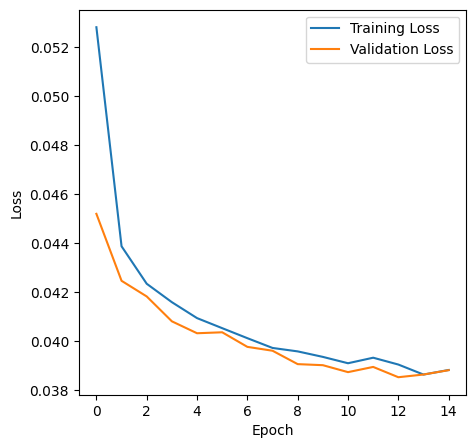

100%|██████████| 15/15 [01:49<00:00,  7.31s/it]

Epoch 15, Training Loss: 0.0388, Validation Loss: 0.0388


In [5]:
# Initialize model and optimizer
set_seed(42)
model = MNISTAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Reconstruction loss
criterion = nn.MSELoss()

# Training loop
train_losses, valid_losses = [], []
for epoch in tqdm(range(15)):
    # Train and Validate
    train_loss = train(model, train_loader, optimizer, criterion, device)
    valid_loss = validate(model, valid_loader, criterion, device)

    # Log losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Clear and update plot
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(valid_losses, label='Validation Loss')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.show()


    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')



We can visualise the reconstruction of the images for a validation batch

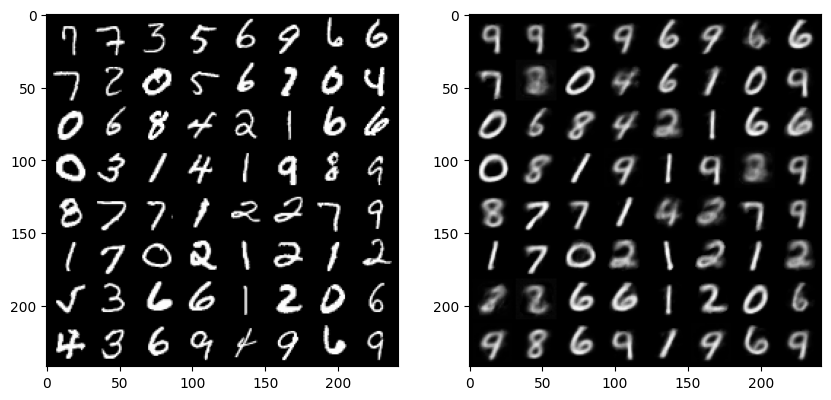

In [6]:
data, _ = next(iter(valid_loader)) # get a batch from the validation loader
data = data[:64]
with torch.no_grad():
  recon = model(data.to(device))

# Make grid of original and reconstructed images
data_grid = make_grid(data, nrow=8, padding=2, normalize=True)[0]
recon_grid = make_grid(recon, nrow=8, padding=2, normalize=True)[0]

# Plot original and reconstructed images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(data_grid.cpu().numpy(), cmap='gray')
axs[1].imshow(recon_grid.detach().cpu().numpy(), cmap='gray')
plt.show()


Not an exceptional result, but it's a start. Possibly better models and more expressive latent spaces (i.e. more than 2 dimensions) would yield better results.

But since our latent space is 2D, we can visualize it. First, let's encode the dataset into their **latent vectors** so we can construct our **latent space**.

In [7]:
latents = []
labels = []

model.eval()
with torch.no_grad():
  for data, label in tqdm(valid_loader):
    latent = model.encode(data.to(device))
    latents.append(latent)
    labels.append(label)


# stack latents
latents = torch.cat(latents, dim=0).cpu().numpy()
labels = torch.cat(labels, dim=0).cpu().numpy()

print(latents.shape, labels.shape)

100%|██████████| 94/94 [00:01<00:00, 78.71it/s]

(12000, 2) (12000,)


Each sample is now represented by a quantity of a latent variable 1 and another quantity of a latent variable 2:

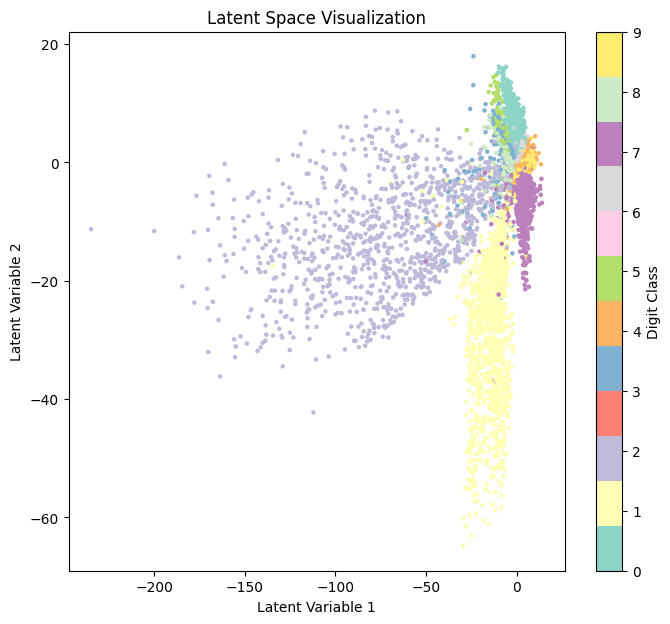

In [8]:
# Plot latents with discrete cmap
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
im = ax.scatter(latents[:, 0], latents[:, 1], c=labels, cmap=plt.cm.Set3, s=5)
ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')
ax.set_title('Latent Space Visualization')
plt.colorbar(im, ax=ax, label='Digit Class')
plt.show()

We can see that the model has learned to represent the data in a way that the classes are somewhat disentangled, although not perfectly.

#### Navigating the latent space

With a trained network, we can navigate the latent space by interpolating between two or more latent vectors. Let's have a look at how this works.

In [9]:
samples, _ = next(iter(valid_loader))
sample_A, sample_B = samples[8].unsqueeze(0), samples[10].unsqueeze(0)

In [10]:
# A very simple interpolation/blending function
def interpolate(x, y, alpha):
    return x*alpha+y*(1-alpha)

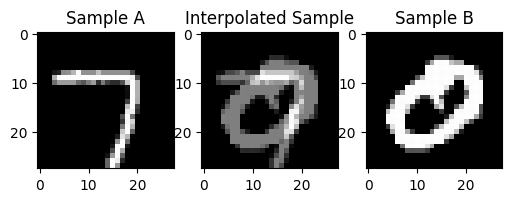

In [11]:
# Baseline: interpolate between samples
sample_interpolated = interpolate(sample_A, sample_B, 0.5)

# Visualize results
fig, ax = plt.subplots(1, 3, figsize=(6, 2))
ax[0].imshow(sample_A[0,0].cpu().numpy(), cmap='gray')
ax[1].imshow(sample_interpolated[0,0].cpu().numpy(), cmap='gray')
ax[2].imshow(sample_B[0,0].cpu().numpy(), cmap='gray')
ax[0].set_title('Sample A')
ax[1].set_title('Interpolated Sample')
ax[2].set_title('Sample B')
plt.show()

Does not look like much. In the latent space this is a bit more interesting.

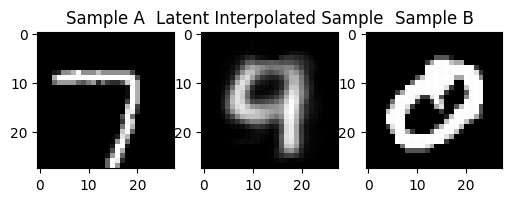

In [12]:
with torch.no_grad():
    # Get latent representations of sample A and B
    latent_A = model.encode(sample_A.to(device))
    latent_B = model.encode(sample_B.to(device))

    # Interpolate between latents
    latent_interpolated = interpolate(latent_A, latent_B, 0.5)

    # Decode interpolated latent
    recon_interpolated = model.decode(latent_interpolated)

# Visualize results
fig, ax = plt.subplots(1, 3, figsize=(6, 2))
ax[0].imshow(sample_A[0,0].cpu().numpy(), cmap='gray')
ax[1].imshow(recon_interpolated[0,0].cpu().numpy(), cmap='gray')
ax[2].imshow(sample_B[0,0].cpu().numpy(), cmap='gray')
ax[0].set_title('Sample A')
ax[1].set_title('Latent Interpolated Sample')
ax[2].set_title('Sample B')
plt.show()

The reconstruction of the interpolated latent variable does not exist in our dataset and does not correspond to any real image. But its reconstruction does seem to belong to the distribution of our data.

We have succesfully generated our first data sample!

But what exactly is happening here? When we navigate the somewhat disentangled latent space of our model, the path between class X and Y may continuously cross class Z. This is a hint that our model is learning something *meaningful* about the data.


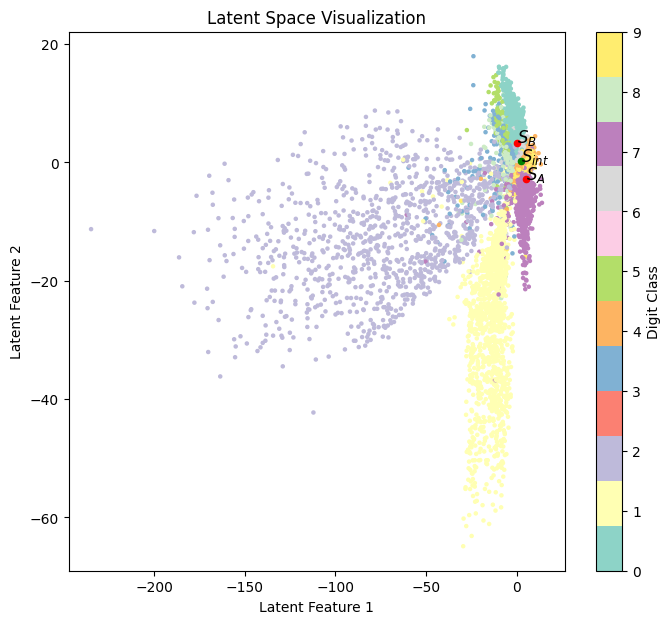

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
im = ax.scatter(latents[:, 0], latents[:, 1], c=labels, cmap=plt.cm.Set3, s=5)
ax.scatter(latent_A[:, 0].cpu(), latent_A[:, 1].cpu(), c='r', s=20)
ax.scatter(latent_B[:, 0].cpu(), latent_B[:, 1].cpu(), c='r', s=20)
ax.scatter(latent_interpolated[:, 0].cpu(), latent_interpolated[:, 1].cpu(), c='g', s=20)
ax.annotate(r'$S_A$', (latent_A[:, 0].cpu(), latent_A[:, 1].cpu()), fontsize=12)
ax.annotate(r'$S_B$', (latent_B[:, 0].cpu(), latent_B[:, 1].cpu()), fontsize=12)
ax.annotate(r'$S_{int}$', (latent_interpolated[:, 0].cpu(), latent_interpolated[:, 1].cpu()), fontsize=12)
ax.set_xlabel('Latent Feature 1')
ax.set_ylabel('Latent Feature 2')
ax.set_title('Latent Space Visualization')
plt.colorbar(im, ax=ax, label='Digit Class')
plt.show()

Now instead of interpolating between vectors, what if we just randomly sample from the latent space?

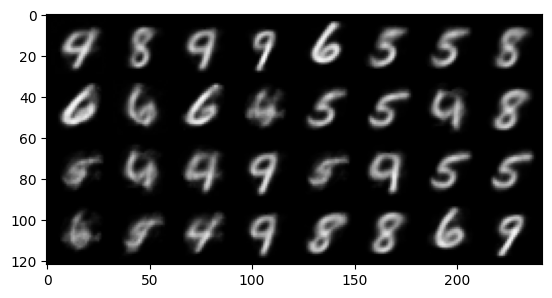

In [14]:
random_latent = torch.randn(32,2)
random_reconstruction = model.decode(random_latent.to(device)).cpu().detach()

# Make grid of random reconstructions and plot
random_grid = make_grid(random_reconstruction)[0]
plt.imshow(random_grid, cmap='gray')
plt.show()

We just generated our first batch of synthetic data, defined only by the random state of our latent vectors and the weights of our model.

---
---

## 2. Variational AutoEncoders

Although Autoencoders can be used for generation, they are not the best choice for this task. Here's why:

<!-- ### **Intuitive motivation**

**Variational Autoencoders (VAEs)** share a similar architecture with Autoencoders, but their goal is not to perform dimensionality reduction. Instead, they learn how to generate new samples that resemble those in the training dataset. They do this by sampling from the latent space of the dataset.

The question is: **could we use an Autoencoder to do this?** Let's look at the 2D latent space of an Autoencoder trained on MNIST: -->


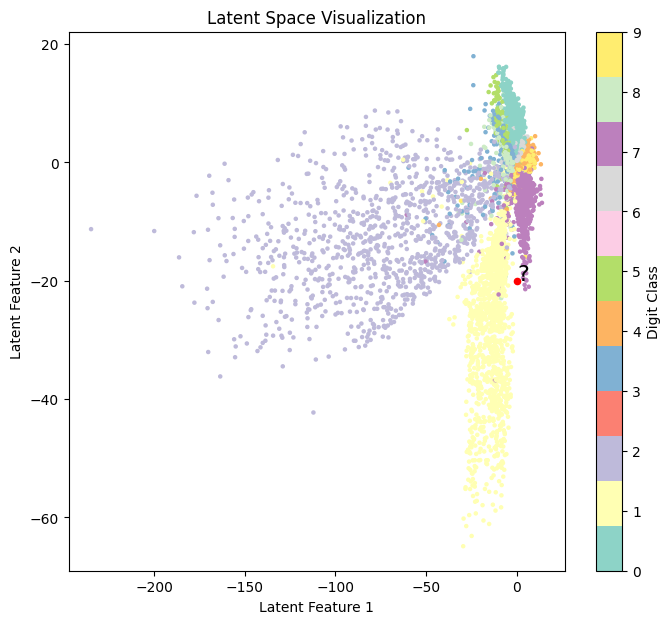

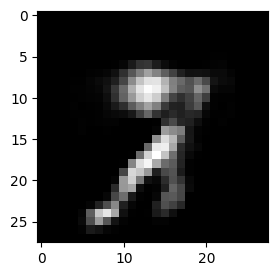

In [15]:
# Let's pick a vector in the "void" of the latent space
z = torch.tensor([[0,-20]], dtype=torch.float32)
recon = model.decode(z.to(device))


# Plot the latent vector in the latent space
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
im = ax.scatter(latents[:, 0], latents[:, 1], c=labels, cmap=plt.cm.Set3, s=5)
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), c='r', s=20)
ax.annotate(r'$?$', (z[:, 0].cpu(), z[:, 1].cpu()), fontsize=16)
ax.set_xlabel('Latent Feature 1')
ax.set_ylabel('Latent Feature 2')
ax.set_title('Latent Space Visualization')
plt.colorbar(im, ax=ax, label='Digit Class')
plt.show()

# Plot the reconstruction
recon = recon.cpu().detach().numpy()
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(recon[0].reshape(28, 28), cmap='gray')
plt.show()


It is clear that sampling from this latent space is be problematic unless remain very close to the training set. Having this constraint would significantly limit our generative freedom.


<!--
<br>

<center>
<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*-i8cp3ry4XS-05OWPAJLPg.png" width="400"/>
</center>

<br> -->




This is where **Variational Autoencoders (VAEs)** come in.

VAEs share the same architecture as Autoencoders, but with a few key differences that explicitly enforce data modelling.

They transform the discrete latent space of autoencoders into a **probabilistic latent space**, where each feature in the latent vector will be a probability distribution:

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1feye1FElxPRhTI0vspSfODltXUJOFkr1&sz=w1500" width="800"/>
</center>

<br>

Intuitively, this means that we are forcing each sample to be described by a range of possible latent values, instead of a single one.

The decoder will then randomly sample from each latent probability distributions and reconstruct the input.

Because sampling from distributions is a stochastic process, every draw introduces intrinsic randomness into the reconstruction process.

So, for **any sample drawn from the latent distribution** of a given input, we drive the decoder to yield an accurate reconstruction, which in turn enforces that neighbouring latent vectors **generate highly similar outputs**.


<br>

<center>
<img src="https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.48.42-PM.png" width="800"/>
</center>

<br>

The result of this enforcement is a latent space that is **smooth, continous and well-structured**, one that we can more freely and confidently navigate.


<br>

<center>
<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*BIDBG8MQ9-Kc-knUUrkT3A.png" width="400"/>
</center>

<br>

<br>

Variational Autoencoders were first introduced in [this 2013 paper](https://arxiv.org/abs/1312.6114), where it was applied to MNIST digits and people's faces:

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1GZLWSscyJr05IPvLFzmzQT_iq-_Lwqi_&sz=w1500" width="1000"/>
</center>

<br>

<br>


### **Encoder**

Now that we understand the intuition behind VAEs, how do we implement a probabilistic latent space?

A probability distribution is defined by a series of parameters. For the normal distribution, for example, these are the mean and variance. We will then modify the bottleneck of the previous Autoencoders so that we can generate a set of parameters for every dimension in the latent space.

Let's say our latent space has two dimensions that are parametrised as Gaussian. Our network would then look similar to this:

<br>

<center>
<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-12.24.19-AM.png" width="800"/>
</center>

<br>

For each of our two latent dimensions we now have two parameters: a mean and a variance. These are grouped together into a mean latent vector and a variance latent vector. Here, we assume that the dimensions of our latent space are completely uncorrelated with each other.

In [16]:
class Encoder(nn.Module):
    def __init__(self, latent_size=2):
        super().__init__()
        self.latent_size = latent_size
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.activation = nn.ReLU()

        # Here our hidden layers split into two: mu and logvar
        # We use logvar instead of var because it is more flexible and numerically stable
        # https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig
        self.mu_layer = nn.Linear(256, latent_size)
        self.logvar_layer = nn.Linear(256, latent_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        # Do we need activation here?
        mu = self.mu_layer(x)
        logvar = self.logvar_layer(x)
        return mu, logvar

### **Decoder**

That covers the encoding process, but what happens with the decoder? How do we sample from these probability distributions?

Recall that we are looking for a sample $z \sim q(z | x)$, that belongs to a Gaussian distribution defined by the parameters $\mu$ and $\sigma$.

We could simply draw random samples from the latent probability distributions using any standard routine for generating Gaussian noise. However, such standard routines rely on non-differentiable stochastic steps, which prevents backpropagation.

A vector of random values, by definition, has no derivative, and so we cannot backpropagate through it.

Fortunately, we can use something called the "reparametrization trick":

<br>

<center>
<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-4.36.34-PM.png" width="800"/>
</center>

<br>

Now we do not need to backpropagate through the random vector!

<br>

<center>
<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-4.39.41-PM.png" width="800"/>
</center>

<br>

Let's now write our decoder and the complete VAE model.


In [17]:
class Decoder(nn.Module):
    def __init__(self, latent_size=2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)
        self.activation = nn.ReLU()

    def forward(self, z):
        x = self.activation(self.fc1(z))
        x = self.activation(self.fc2(x))

        # We use a sigmoid activation for the final layer
        # to ensure that the output is always in the range [0, 1]
        x = torch.sigmoid(self.fc3(x))
        return x.view(-1, 1, 28, 28)


class MNISTVAE(nn.Module):
    def __init__(self, latent_size=2):
        super().__init__()
        self.latent_size = latent_size
        self.encode = Encoder(latent_size)
        self.decode = Decoder(latent_size)

    def sample(self, mu, log_var):
        """ This method applies the reparameterization trick """
        std = torch.exp(0.5*log_var)
        eps = torch.rand_like(std)
        return mu + std*eps

    def forward(self, x):
        mu, log_var = self.encode(x)
        x = self.sample(mu, log_var)
        return self.decode(x), mu, log_var   # return the decoded image, the mean and the log variance

In [18]:
model = MNISTVAE()
recon, mu, log_var = model(torch.zeros(1,1,28,28))

In [19]:
recon.shape, mu.shape, log_var.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 2]), torch.Size([1, 2]))

---
---

### **Loss function**

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1kz-B9iKAWLBghJ4nrsNZrg2pqfFy-yT6&sz=w1500" width="1000"/>
</center>

<br>

The loss function of the VAE contains two terms:

$$
\mathcal{L}_{VAE} = \mathcal{L}_{recon}(x_i,  x_i') + \sum_j KL \, (q_{\theta}^j(z|x) \, || \, p(z)),
$$

where $KL(q_{\theta}(z|x) || p(z))$ is the Kullback-Leibler divergence between the encoder distribution $q_{\theta}(z|x)$ and the prior $p(z)$ of our choice. Usualy we use the unit Gaussian as prior because it is a simple distribution with nice mathematical properties.

The first term is, like with Autoencoders, a measure of reconstruction error between the input of the encoder $x_i$ and the output of the decoder $\hat x_i$. This could be, for example, the MSE loss.

The second term acts as a **regulariser**, which encourages the distributions that the VAE learns to remain close to a prior probability distribution $p(z)$ for every dimension $j$ of the latent space. The intution is this:

<br>

<center>
<img src="https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.51.06-PM.png" width="800"/>
</center>

<br>


<br>

Recall from yesterday's lecture that a special closed-form case of the KL Divergence occurs between two Gaussian distributions. If one of the distributions is a unit Gaussian ($\mu = 0$, $\sigma = 1$), then the closed-form is further simplified to:

<br>

$$
KL \, (q_{\theta}(z|x) \, || \, p(z)  ) = - \frac{1}{2} \sum_j (1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2)
$$

<br>

Since we model our latent variables as Gaussian distributions, we can use this closed-form expression to calculate the KL Divergence between them and the unit Gaussian we choose as our prior.



In [20]:
def kl_divergence(mean, log_var):
    return -0.5*torch.sum(1+log_var-mean.pow(2)-log_var.exp())

We now have everything we need to train our VAE. First, we need to modify our training and validation functions. We can also add a KL divergence weight to balance the reconstruction and KL divergence losses.

In [21]:
def train(model, dataloader, optimizer, criterion, device, klw):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, log_var = model(data)
        loss = criterion(recon, data) + klw*kl_divergence(mu, log_var) # add KL divergence to reconstruction loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)
    return train_loss / len(dataloader.dataset)

def validate(model, dataloader, criterion, device, klw):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon, mu, log_var = model(data)
            loss = criterion(recon, data) + klw*kl_divergence(mu, log_var)
            valid_loss += loss.item() * len(data)
    return valid_loss / len(dataloader.dataset)

Everything else is the same as we did in the Autoencoder example

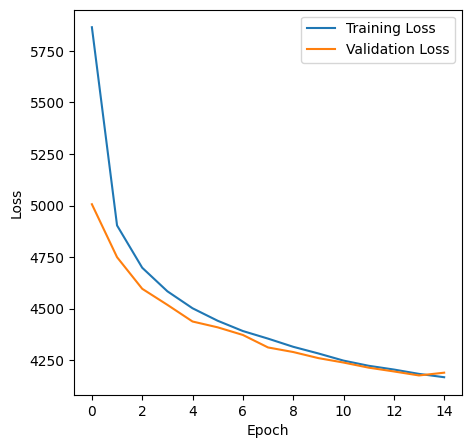

100%|██████████| 15/15 [01:51<00:00,  7.43s/it]

Epoch 15, Training Loss: 4167.4049, Validation Loss: 4189.3848


In [22]:
# Initialize model and optimizer
set_seed(42)
model = MNISTVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
kl_weight = 1.0

# Reconstruction loss
criterion = nn.MSELoss(reduction='sum')

# Training loop
train_losses, valid_losses = [], []
for epoch in tqdm(range(15)):
    # Train and Validate
    train_loss = train(model, train_loader, optimizer, criterion, device, kl_weight)
    valid_loss = validate(model, valid_loader, criterion, device, kl_weight)

    # Append to lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Clear and update plot
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(valid_losses, label='Validation Loss')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.show()


    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')



In [28]:
latents = []
labels = []

model.eval()
with torch.no_grad():
    for data, label in tqdm(valid_loader):
        data = data.to(device)
        mu, log_var = model.encode(data)
        z = model.sample(mu, log_var)
        latents.append(z)
        labels.append(label)

# stack latents
latents = torch.cat(latents, dim=0).cpu().numpy()
labels = torch.cat(labels, dim=0).cpu().numpy()

print(latents.shape, labels.shape)

100%|██████████| 94/94 [00:01<00:00, 76.30it/s]

(12000, 2) (12000,)


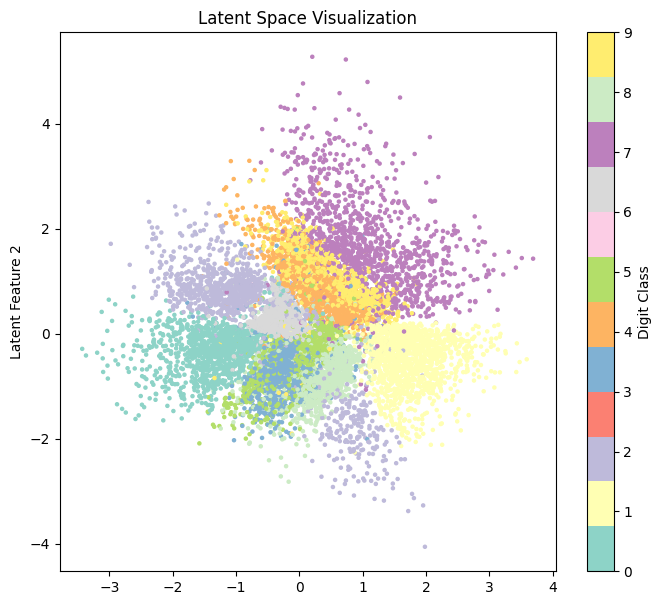

In [29]:
# Plot latents with discrete cmap
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
im = ax.scatter(latents[:, 0], latents[:, 1], c=labels, cmap=plt.cm.Set3, s=5)
ax.set_ylabel('Latent Feature 2')
ax.set_title('Latent Space Visualization')
plt.colorbar(im, ax=ax, label='Digit Class')
plt.show()

As expected, the latent space is smoother, more continuous. Another nice property is that the range of values in our latent vectors is bound to that of a unit Gaussian, like our prior. So we can simply sample from a unit Gaussian and get a valid latent vector:

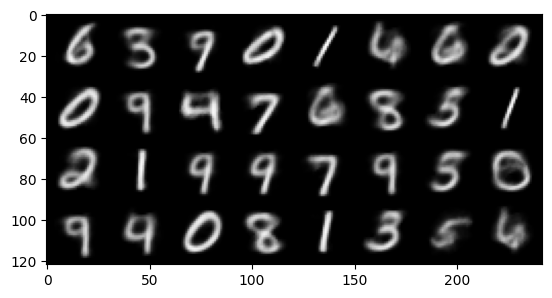

In [34]:
with torch.no_grad():
    z = torch.randn(32,2)  # draw random samples directly from the prior we train our model to learn
    random_reconstruction = model.decode(z.to(device)).cpu().detach()

random_grid = make_grid(random_reconstruction)[0]
plt.imshow(random_grid, cmap='gray')
plt.show()


We can see the impact of each term in the loss in this figure:

<br>

<center>
<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-7.22.24-PM.png" width="800"/>
</center>

<br>



#### **Evidence Lower Bound (ELBO)** (Advanced)

It is by design that minimising $\mathcal{L}_{VAE}$ is equivalent to maximising something called the [**Evidence Lower Bound (ELBO)**](https://en.wikipedia.org/wiki/Evidence_lower_bound):

$$
ELBO = \mathbb{E}_{q(z|x)}[\log p(x|z)] - \mathbb{E}_{q(z|x)}[KL(q(z|x) || p(z))]
$$

The ELBO is also sometimes referred to as the **variational lower bound**, which is where the name "variational" comes from.

Remember that generative models aim to capture the underlying data distribution by maximising the likelihood of the observed data under the model $p(x)$. When this approximation is successful, the model can then draw new samples that lie close to the original data.

However, how can we push our model towards the very distribution we are trying to learn? It's for this reason that the ELBO is an important quantity in deep learning: it provides **tractable** (i.e. easy to compute) **lower bound** on the log-likelihood of the data under the model $p(x)$.

Therefore, by maximising the ELBO, we are effectively pushing our model towards the very distribution we are trying to learn without ever having to explicitly compute it.

Although an important concept in deep learning, you don't need to know the ELBO to use VAEs. It is just a tool that helps us understand the inner workings of the model. It does not fall within the scope of this course and therefore is not assessed. For those who are interested, you can find a more in-depth explanation [here](https://lilianweng.github.io/posts/2018-08-12-vae/) and [here](https://www.jeremyjordan.me/variational-autoencoders/)

<br>

---

<br>

## 3. Other VAE architectures

### **Conditional VAEs**

There is one type of VAE that is of special interest in generative problems: **Conditional Variational AutoEncoders (cVAEs)**.

We have been looking at how VAEs can learn latent representations of a dataset, which can then be used to generate new, original data points. However, what happens if we want to constrain the decoder to produce examples within a certain category?

cVAEs address this by introducing an additional conditional input $c$ to both the encoder and the decoder:

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1CuNqPhxOCkkwTN7HtIInKo7o3JsppUic&sz=w1500" width="600"/>
</center>

<br>

This conditional information could contain, for example, a hot-encoded label. We could use this in the case of MNIST to generate specific digits after training.

### **Very Deep VAEs**

In an attempt to improve the performance of VAEs, we could try to increase the amount of layers. However, doing this naively results in limited performance improvements.

Instead, researchers have proposed [**Very Deep Variational AutoEncoders (VDVAEs)**](https://arxiv.org/pdf/2011.10650) as a way to enable increasing performance with increasingly large layer count.

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1YfybnjKu155INV-Mg4wJrFhwfC_ujkwO&sz=w1500" width="700"/>
</center>

<br>

VDVAEs are based on the construction of intermediate latent spaces at the end of every block, creating a multi-scale latent representation. Each convolution is preceded by the GELU non-linearity. In this diagram, $q_φ$ and $p_Θ$ are diagonal Gaussian distributions (parametrised by their mean and variance), and $z$ is sampled from $q_φ$ during training and $p_Θ$ when sampling.

**Does this architecture look familiar?**

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1LXs4wzJxvjPu_yhFCqRoyHQcv4hepJfV&sz=w1500" width="700"/>
</center>

<br>

<br>

---

<br>

## 4. A simple VAE demo

Check out this VAE demo where you can play with the latent space:

In [ ]:
%%html
<iframe src="https://www.siarez.com/projects/variational-autoencoder" width="1000" height="800">
</iframe>

<br>

---

<br>